In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
import matplotlib.pyplot as plt
from glob2 import glob

from tqdm import tqdm
from swath_rossby_wave import skill_matrix, build_h_matrix2, build_hswath_matrix2
from swath_rossby_wave import inversion, make_error_over_time

In [2]:
# set standard deviation of error parameters
alpha_std = np.arange(5e-4, 3.05e-2, 1e-3)

In [3]:
# set basic parameters:  dates, longitude/latitude range
day0, day1 = 0, 40 # 
Tdim = day1 - day0
n_waves = '190' #number of waves
time_range = 2 * (day1 - day0) # assimilation + forecast window

MModes = 1 # Rossby wave vertical modes
wave_files = glob('./rossby_wave_estimate_*_' + n_waves + 'waves_swotdomain_40days.nc')
wave_files = sorted(wave_files)

lonidx_west, lonidx_east  =  74, 110
latidx_south, latidx_north = 25, 65

# read AVISO data and demean to obtain background mask
aviso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')

SSHA = aviso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]
# remove mean over full study period to produce anomaly.  
SSHA = SSHA-SSHA[:].mean(axis = -1)
# alternatively # remove 80-day mean  SSHA[day0 + day0 + 30].mean(axis = -1)

# read in data to get mask
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked[:,:,day0:(day1-day0)*2])
lon, lat = (360 - aviso_ds.lon[lonidx_west:lonidx_east].data) * -1, aviso_ds.lat[latidx_south:latidx_north].data
T_time = aviso_ds.time.data[day0:] * 86400 # in seconds
date_time = aviso_ds.date_time.data[day0:]

# set background parameters for propagating Rossby wave model
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0*np.pi/180.) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0*np.pi/180.) #1.0313e-4 # 45 N

# noise and error scaling are hardwired but can be changed.
# R = 0.001 # noise = 3.1 cm
R = 0.01 # noise = 10. cm  ##default
# R = 0.1 # noise = 31. cm
# sigma_scale = 0.65 # scale so that RMS correlated error matches applied sigma (empirically derived)
sigma_scale = 1.00 # default
# sigma_scale = 0.3 # effective sigma smaller than RMS correlated error
# sigma_scale = 1.5 # effective sigma comparable to RMS correlated error

In [4]:
# list SWOT data files
swot_files = sorted(glob('./SWOT_L2_LR_SSH_Expert_474*.nc'))

In [5]:
# identify SWOT tracks---here using only 2 sample tracks from one-day repeat orbit
swot_files = sorted(glob('./SWOT_L2_LR_SSH_Expert_474*.nc'))
swot_ds = xr.open_mfdataset(swot_files, combine='nested', concat_dim = 'num_lines') # , engine='store', chunks={'time': 10})


In [6]:
# Read swot_ds to identify SWOT data coordinates

# Extract the nadir position for the ground track
latitude_nadir = swot_ds['latitude_nadir'].values
longitude_nadir = swot_ds['longitude_nadir'].values-360

# Extract the latitudes and longitudes within the swath
latitude = swot_ds['latitude'].values
longitude = swot_ds['longitude'].values-360

# read cross track distance, and depth
cross_track = swot_ds['cross_track_distance'].values
depth=swot_ds['depth_or_elevation'].values

# use a brute-strength approach to separate ascending and descending tracks
direction = np.sign(np.diff(latitude,n=1,axis=0))

# to tightly distinguish ascending and descening, use time difference between reference tracks
time_swot = swot_ds['time'].values
time_hrs=time_swot[:].astype('datetime64[h]').astype(int)-466680
direction_asc = np.all([time_hrs >5,time_hrs < 11],axis=0)
direction_des = np.all([time_hrs >=11,time_hrs < 22],axis=0)

In [7]:
# prepare a mask for in-swath vs out-of-swath data
mask_asc=np.zeros([len(lat),len(lon)])
mask_des=np.zeros([len(lat),len(lon)])
mask_total=np.zeros([len(lat),len(lon)])

y1=latitude[:,2]
x1=longitude[:,2]
y2=latitude[:,66]
x2=longitude[:,66]
index_asc=np.where(direction_asc[:])
lon_edge1=np.interp(lat,y1[index_asc],x1[index_asc])
lon_edge2=np.interp(lat,y2[index_asc],x2[index_asc])
index_des=np.where(direction_des[:])
lon_edge3=np.interp(lat,np.flip(y1[index_des]),np.flip(x1[index_des]))
lon_edge4=np.interp(lat,np.flip(y2[index_des]),np.flip(x2[index_des]))
for i in range(len(lat)):
    for j in range(len(lon)):
        if(lon[j]>=lon_edge1[i] and lon[j]<=lon_edge2[i]):
            mask_asc[i,j]=1
        if(lon[j]<=lon_edge3[i] and lon[j]>=lon_edge4[i]):  # descending order reversed
            mask_des[i,j]=1.  
        if(mask_asc[i,j]==1 or mask_des[i,j]==1):
            mask_total[i,j]=1 

In [8]:
# Arrays to store variance explained
nsigma=len(alpha_std)
nfiles=len(wave_files)
variance_explained_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_persistence = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_persistence = np.zeros([nfiles, nsigma, time_range])
variance_explained_persistence = np.zeros([nfiles, nsigma, time_range])

In [9]:
# define stratification for Rossby wave model
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')
Psi = strat_ds.Psi.data

# set longitude and latitude anomalies relative to mean
dlon = lon - lon.mean()
dlat = lat - lat.mean()

# pre-fill output arrays with zeros
rms_err, rms_ssh = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
rms_err2, rms_ssh2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

ssh_est_skill2, err_est_skill2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

ssh_est_skill1, err_est_skill1 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

total_est_skill1, total_est_skill2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
err_proj_err, ssh_proj_err = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
err_proj_err2, ssh_proj_err2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])
noise_proj_err, noise_proj_err2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

In [10]:
# read in first file and configure basic matrix information
n=0
ndays=day1-day0

wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
MSLA_fwd = np.ma.masked_where(ssha_mask,MSLA_fwd)

Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

l_n = l_n_orig.reshape(len(l_n_orig), MModes)
k_n = k_n_orig.reshape(len(k_n_orig), MModes)

MSLA0 = MSLA_fwd[:, :, day0:day1]

### assess skill, get indices
# note that this measure of skill is not used subsequently
# code was written this way to test fraction of variance explained by each wavenumber combination
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

M = k_n.size * l_n.size # Number of models/waves

# define matrix inversion, accounting for land gaps
# matrix H_all is consistent for all start dates
H_all, SSHA_vector = build_h_matrix2(MSLA0, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0-day0)

# create a dummy masked matrix in order to build the full H matrix
ssha_clean = np.ma.masked_invalid(np.zeros([MSLA0.shape[0],MSLA0.shape[1],MSLA0.shape[2]]))

# create full matrices, no land gaps, to faciliate projection
# matrices are consistent for all start dates
H_all_full_grid, SSHA_vector_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0-day0)
H_all_full_grid2, SSH_vector2_full = build_h_matrix2(ssha_clean, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, ndays)

In [11]:
ssh_reconstructed=np.matmul(H_all_full_grid, amp)

In [12]:
# identify points to use within swath and remove swath points that won't be used
mask=np.zeros([latitude.shape[0],latitude.shape[1]])
deltax=np.zeros([latitude.shape[0],latitude.shape[1]])
asc_des=np.zeros([latitude.shape[0],latitude.shape[1]])

# chose cross-track positions
#  original code used range(3,latitude.shape[1],8):
# a better version would center on zero, but this risks picking up values from the
# Heavisde for both the left and right swaths
use2=[2, 10, 18, 26,42,50,58,66]

deltax=cross_track/1.e5 # distance in 100 km, relative to nadir
asc_des=(direction+1)/2.  ## 1 = ascending; 0 = descending
for i in range(0,latitude.shape[0]-1,16):
    for j in use2:
        if(latitude[i,j]>=min(lat) and latitude[i,j]<=max(lat) and depth[i,j]<=0 
           and longitude[i,j]<=max(lon) and longitude[i,j]>=min(lon)):
            mask[i,j]=1
        

index=np.where(mask==1)

In [14]:
# define an H matrix for swath points only
H_swath = build_hswath_matrix2(ssha_clean, MModes, k_n, l_n, lon,lat,longitude, latitude, index, T_time, Psi, Rm, day0-day0)

In [15]:
# set indices for correlated error, by counting backwards
IND_TIMING = -7 
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [16]:
# define H matrix for correlated error terms
Valid_points = len(index[0]) 
err_basis_func = np.zeros([Valid_points, 2, 7])
H_swath_roll = np.zeros([Tdim*Valid_points,Tdim*14])

tt=0
for ii in range(len(index[0])):
    iuse=index[0][ii]
    juse=index[1][ii]
    iasc=int(asc_des[iuse,juse])
    #timing error
    err_basis_func[ii, iasc, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    err_basis_func[ii, iasc, IND_ROLL] = deltax[iuse,juse]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    err_basis_func[ii, iasc, IND_BASELINE] = deltax[iuse,juse]**2  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * deltax[iuse,juse], 1) #
    H_pos = np.heaviside(deltax[iuse,juse], 1) # 
    err_basis_func[ii, iasc, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    err_basis_func[ii, iasc, IND_PHASE4] = deltax[iuse,juse] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    err_basis_func[ii, iasc, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    err_basis_func[ii, iasc, IND_PHASE6] = deltax[iuse,juse] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
 
err_basis_func=err_basis_func.reshape([Valid_points, 14])
    
for tt in range(Tdim):
    H_swath_roll[tt*Valid_points:(tt+1)*Valid_points, tt * 14 : (tt+1) * 14] = err_basis_func

In [17]:
# build total H matrix for in-swath data by concatenating Rossby wave and correlated error matrices
H_swath_total = np.concatenate((H_swath, H_swath_roll),axis=1)

In [18]:
# diagnostic:  reconstruct "true" data on swath
map_swath=np.matmul(H_swath,amp)

In [19]:
# set time duration 
Tdim=day1-day0

In [20]:
#  build covariance matrix:  R over P

counter = 0
exp = -2
ssh_std = .1
k0 = k_n.max() # flat at or below k0 

M = l_n.size * k_n.size
p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(k_n)*len(l_n)), np.zeros(len(k_n)*len(l_n))
counter = 0

for kk in k_n:
    for ll in l_n:
        k_[counter] = kk 
        l_[counter]  = ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

R_over_P = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(R_over_P[:],  R / p_diagonal / p_factor)

/tmp/ipykernel_2328990/3421246840.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] = kk
/tmp/ipykernel_2328990/3421246840.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  l_[counter]  = ll
/tmp/ipykernel_2328990/3421246840.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


In [21]:
# redo R_over_P adding in covariance for roll error; this will change with each assumed roll error uncertainty
sigma=alpha_std[10]  ## temporary value to set up matrix
p_diagonal = np.diagonal(R_over_P)
p_diagonal_roll = np.zeros([Tdim * 7*2])
p_diagonal_roll[:] = R/sigma ** 2 
R_over_P_total = np.zeros([len(p_diagonal)+len(p_diagonal_roll),len(p_diagonal)+len(p_diagonal_roll)])

np.fill_diagonal(R_over_P_total[:],  np.concatenate((p_diagonal,p_diagonal_roll)))

In [22]:
# Two-stage approach: reconstructing the SSH separately from solving the correlated error

# First step: fit errors
H_v1 = H_swath_total[:, -7 *2* Tdim:]
R_over_P1 = R_over_P_total[-7*2* Tdim:, -7*2* Tdim:]
HTH = np.matmul(H_v1.T, H_v1)
HRH = HTH + R_over_P1 # P: uncertainty in model, R: uncertainty in data
D1 = np.matmul(LA.inv(HRH), H_v1.T)

In [23]:
# second step: fit residual to rossby wave models

H_v = H_swath_total[:, :-7 *2* Tdim]
HTH = np.matmul(H_v.T, H_v)
HRH = np.zeros(HTH.shape)
HRH = HTH +  R_over_P_total[:-7 *2* Tdim, :-7 *2* Tdim]  # !!!  move into loop
D2 = np.matmul(LA.inv(HRH), H_v.T)

In [25]:
# now loop through all files
iref=20 # reference time step for persistence
with tqdm(total= rms_err[:,0].size) as pbar:
    for n in range(len(wave_files)):
        wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
        MSLA_fwd = wave_ds.MSLA_forward.data
        MSLA_fwd = np.ma.masked_where(ssha_mask,MSLA_fwd)
        temp=MSLA_fwd[:,:,:40].transpose([2,0,1])
        MSLA_vector=np.ma.compressed(temp.flatten())
 
        amp_recovered, ssh_estimated = inversion(MSLA_vector, H_all, R_over_P)
        
        # map "true" data on swath
        amp = wave_ds.Amplitudes.data
        ssh=np.matmul(H_swath,amp)
        N=len(ssh)
        
    
        # Loop over sigma
        sigma_counter = 0
        
        for sigma in alpha_std: # std of error amp

            # Add errors to the swaths
            mu = 0
            time_factor = np.arange(1, 1 + day1-day0)
            # generate error parameter with Gaussian distribution
            np.random.seed(n*len(alpha_std)+sigma_counter)# optional:  use random number seed to support reproducibility
            alpha=np.random.normal(mu,sigma,[Tdim,7,2]) # set up an array of Gaussian random numbers as parameters for roll error

            # produce correlated error
            cor_err  = make_error_over_time(range(day1-day0), alpha, latitude[index], longitude[index], deltax[index], asc_des[index])
            
            np.random.seed(10000000+n*len(alpha_std)+sigma_counter)# optional:  use random number seed to support reproducibility
            noise = np.random.normal(0.,0.02,N)
            
            input_swath = ssh +cor_err.reshape([len(map_swath)])

            p_diagonal_roll[:] = R/(sigma*sigma_scale) ** 2 # errors---scale to make prior error match inserted variance
            R_over_P_total = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])           
            np.fill_diagonal(R_over_P_total[:],  np.concatenate((p_diagonal,p_diagonal_roll)) )
            
            # 1-stage approach, solve for amplitudes            
            amp_1step, ssh_estimated_swath = inversion(input_swath, H_swath_total, R_over_P_total)

            # now use 1-stage approach amplitudes to map data onto AVISO grid
            MSLA_fwrd=np.matmul(H_all_full_grid, amp_1step[:H_all_full_grid.shape[1]])
            MSLA_fwrd=MSLA_fwrd.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd=MSLA_fwrd.transpose((1,2,0))
            MSLA_fwrd = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd)
    
            MSLA_fwrd2=np.matmul(H_all_full_grid2, amp_1step[:H_all_full_grid.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.transpose((1,2,0))
            MSLA_fwrd2 = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2)
            MSLA_fwrd_1step = np.concatenate((MSLA_fwrd,MSLA_fwrd2),axis=2)
    
            # 1-stage approach, solve for amplitudes

            # within the swath, estimate the errors and ssh : H * amp
            err_est_1step = np.matmul(H_swath_total[:, -7*2*Tdim:], amp_1step[-7*2*Tdim:])
            ssh_est_1step = np.matmul(H_swath_total[:, :-7*2*Tdim], amp_1step[:-7*2*Tdim])

            # Important result: error estimate skill and ssh estimate skill of the entire time series
            ssh_diff = ssh_est_1step - ssh
            err_diff = err_est_1step - cor_err.reshape([len(map_swath)])
            ssh_diff1 = (np.mean(ssh_diff**2)) / (np.var(ssh))
            err_diff1  = (np.mean(err_diff**2)) / (np.var(cor_err))
            total_diff1 = np.mean((err_diff+ssh_diff)**2) / (np.var(input_swath))
            
            # Two-stage approach: reconstructing the SSH separately from solving the correlated error
            #  First step: fit errors; R over P matrix varies in time, so need to recompute
            H_v1 = H_swath_total[:, -7 *2* Tdim:]
            R_over_P1 = R_over_P_total[-7*2* Tdim:, -7*2* Tdim:]
            HTH = np.matmul(H_v1.T, H_v1)
            HRH = HTH + R_over_P1 # P: uncertainty in model, R: uncertainty in data
            D = np.matmul(LA.inv(HRH), H_v1.T)
            amp_err = np.matmul(D, input_swath)
            error_projection = np.matmul(D,cor_err.reshape([len(map_swath)]))
            signal_projection = np.matmul(D,ssh)
            noise_projection = np.matmul(D,noise)
            
            # correlated errors have different R over P with time,, so recompute
            err_est_2step = np.matmul(H_v1, amp_err) #### estimate the correlated error
            err_est_proj = np.matmul(H_v1, error_projection) #### estimate the correlated error
            ssh_est_proj = np.matmul(H_v1, signal_projection) #### estimate the correlated error
            noise_est_proj = np.matmul(H_v1, noise_projection) #### estimate the correlated error
            
            # second step: fit residual to rossby wave models
            # matrix does not vary, so skip recomputing
            tau_ssh = input_swath - err_est_2step
            amp_swath_2step = np.matmul(D2, tau_ssh)
            amp_err_projection = np.matmul(D2, cor_err.reshape([len(map_swath)]))
            amp_ssh_projection = np.matmul(D2, ssh)
            amp_noise_projection = np.matmul(D2, noise)
            ssh_est_2step = np.matmul(H_v, amp_swath_2step) #### Reconstruct ssh with new amplitudes in the next 40 days
            ssh_err_projection = np.matmul(H_v, amp_err_projection) #### project noise onto Rossby waves
            ssh_signal_projection = np.matmul(H_v, amp_ssh_projection) #### project signal onto Rossby wavess
            ssh_noise_projection = np.matmul(H_v, amp_noise_projection) #### project signal onto Rossby wavess
            
            # Important result: 2-stage error estimate skill and ssh estimate skill relative to swath data
            ssh_diff = ssh_est_2step - ssh
            err_diff = err_est_2step - cor_err.reshape([len(map_swath)])
            #err_err_diff = err_est_proj - cor_err.reshape([len(map_swath)])
            #err_err_diff2 = ssh_err_projection - cor_err.reshape([len(map_swath)])
            #err_err_diff3 = ssh_err_projection - ssh
            #ssh_ssh_diff = ssh_est_proj - ssh
            #ssh_ssh_diff2 = ssh_signal_projection - ssh
            ssh_diff_2stage = (np.mean(ssh_diff ** 2)) / (np.var(ssh))
            err_diff_2stage = (np.mean(err_diff ** 2)) / (np.var(cor_err))
            #ssh_diff_err_proj = (np.mean(ssh_ssh_diff ** 2)) / (np.var(ssh))
            ssh_diff_err_proj = (np.var(ssh_est_proj)) / (np.var(ssh))
            #err_diff_err_proj = (np.mean(err_err_diff ** 2)) / (np.var(cor_err))
            err_diff_err_proj = (np.var(err_est_proj)) / (np.var(cor_err))
            #ssh_diff_err_proj2 = (np.mean(ssh_ssh_diff2 ** 2)) / (np.var(ssh))
            ssh_diff_err_proj2 = (np.var(ssh_signal_projection)) / (np.var(ssh))
            #err_diff_err_proj2 = (np.mean(err_err_diff2 ** 2)) / (np.var(cor_err))
            err_diff_err_proj2 = (np.var(ssh_err_projection)) / (np.var(cor_err))
            noise_diff_err_proj = (np.var(noise_est_proj)) / (np.var(noise))
            noise_diff_err_proj2 = (np.var(ssh_noise_projection)) / (np.var(noise))
            total_diff_2stage = np.mean((err_diff+ssh_diff)**2) / (np.var(input_swath))
            
            # Root mean squared err/ssh
            rms_err[n, sigma_counter] = np.sqrt(np.mean(cor_err ** 2))
            rms_ssh[n, sigma_counter]= np.sqrt(np.mean(ssh ** 2))
            rms_err2[n, sigma_counter] = np.std(cor_err)
            rms_ssh2[n, sigma_counter]= np.std(ssh)

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_est_skill2[n, sigma_counter], err_est_skill2[n, sigma_counter] = (1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100 # percentage,
            total_est_skill2[n, sigma_counter] = (1 - total_diff_2stage.mean()) * 100
            err_proj_err[n, sigma_counter], ssh_proj_err[n, sigma_counter] = (err_diff_err_proj.mean()) * 100, (ssh_diff_err_proj.mean()) * 100 # percentage,
            err_proj_err2[n, sigma_counter], ssh_proj_err2[n, sigma_counter] = (err_diff_err_proj2.mean()) * 100, (ssh_diff_err_proj2.mean()) * 100 # percentage,
            noise_proj_err[n, sigma_counter], noise_proj_err2[n, sigma_counter] = (noise_diff_err_proj.mean()) * 100, (noise_diff_err_proj2.mean()) * 100 # percentage,            #err_proj_err[n, sigma_counter], ssh_proj_err[n, sigma_counter] = (1 - err_diff_err_proj.mean()) * 100, (1 - ssh_diff_err_proj.mean()) * 100 # percentage,
            #err_proj_err2[n, sigma_counter], ssh_proj_err2[n, sigma_counter] = (1 - err_diff_err_proj2.mean()) * 100, (1 - ssh_diff_err_proj2.mean()) * 100 # percentage,
                        
            # Important result: 1-stage error estimate skill and ssh estimate skill
            ssh_est_skill1[n, sigma_counter], err_est_skill1[n, sigma_counter] = (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 # percentage,
            total_est_skill1[n, sigma_counter] = (1 - total_diff1.mean()) * 100
            
            # now use 2-stage approach amplitudes to map data onto AVISO grid
            MSLA_fwrd=np.matmul(H_all_full_grid, amp_swath_2step)
            MSLA_fwrd=MSLA_fwrd.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd=MSLA_fwrd.transpose((1,2,0))
            MSLA_fwrd = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd)
    
            MSLA_fwrd2=np.matmul(H_all_full_grid2, amp_swath_2step)
            MSLA_fwrd2=MSLA_fwrd2.reshape([ndays,MSLA0.shape[0],MSLA0.shape[1]])
            MSLA_fwrd2=MSLA_fwrd2.transpose((1,2,0))
            MSLA_fwrd2 = np.ma.masked_where(np.ma.getmask(MSLA0),MSLA_fwrd2)
            MSLA_fwrd_2step = np.concatenate((MSLA_fwrd,MSLA_fwrd2),axis=2)
            
            for i in range(time_range):
                # Masking the in-track and out-of-track data
                msla_in = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwd[:, :, i])
                msla_out = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwd[:, :, i])

                # Apply the same mask to the predicted data
                msla_fwrd_in_1step = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwrd_1step[:, :, i])
                msla_fwrd_out_1step = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwrd_1step[:, :, i])
                msla_fwrd_in_2step = np.ma.masked_where(mask_total[:, :] == 0, MSLA_fwrd_2step[:, :, i])
                msla_fwrd_out_2step = np.ma.masked_where(mask_total[:, :] == 1, MSLA_fwrd_2step[:, :, i])

                # Variance of original data for in-swath and out-of-swath
                original_var_in = np.var(msla_in)
                original_var_out = np.var(msla_out)

                # Variance of predictions for in-swath and out-of-swath (1-step)
                predicted_var_in_1step = np.var(msla_fwrd_in_1step)
                predicted_var_out_1step = np.var(msla_fwrd_out_1step)

                # Variance of predictions for in-swath and out-of-swath (2-step)
                predicted_var_in_2step = np.var(msla_fwrd_in_2step)
                predicted_var_out_2step = np.var(msla_fwrd_out_2step)

                # Variance explained (1-step)
                variance_explained_1step[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_1step[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_1step[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_1step)**2) / np.var(msla_in)
                variance_explained_out_1step[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_1step)**2) / np.var(msla_out)

                # Variance explained (2-step)
                variance_explained_2step[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_2step[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_2step[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_2step)**2) / np.var(msla_in)
                variance_explained_out_2step[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_2step)**2) / np.var(msla_out)
                        
                 # Variance explained (persistence)
                variance_explained_persistence[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,iref] - MSLA_fwd[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_persistence[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,iref] - msla_in)**2) / np.var(msla_in)
                variance_explained_out_persistence[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,iref] - msla_out)**2) / np.var(msla_out)
                        
                     
            sigma_counter += 1

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [16:22<00:00, 81.89s/it]


In [27]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)

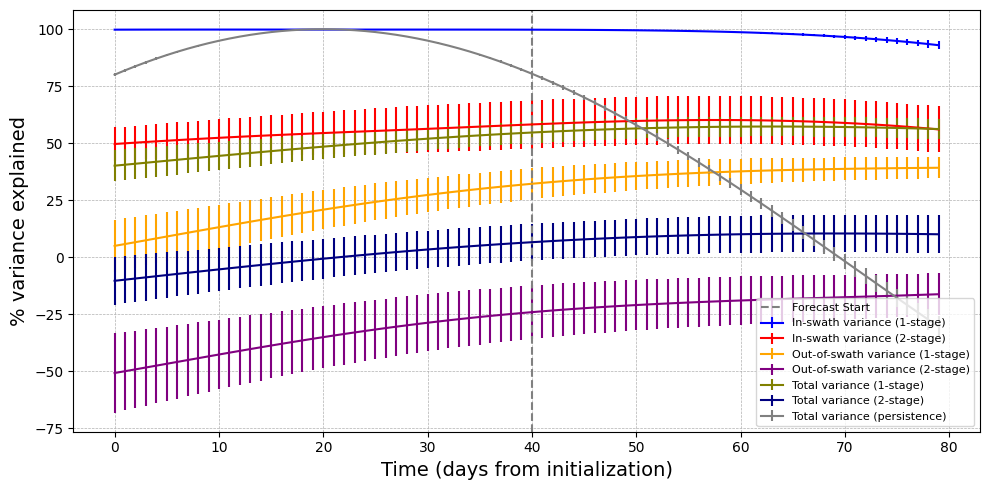

In [28]:
# Figure 8:  Fraction of SSH variance explained as a function of time, in-swath and out-of-swath
# Set figure size and aspect ratio for landscape orientation
fig, ax = plt.subplots(figsize=(10, 5))
# from alpha_std, choose the error amplitude to be plotted here
ialpha=12

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy']

# Line plots
ax.errorbar(range(time_range), (1- variance_explained_in_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_1step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath variance (1-stage)', elinewidth=1.5, color=colors[0])
ax.errorbar(range(time_range), (1-variance_explained_in_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_2step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath variance (2-stage)', elinewidth=1.5, color=colors[2])
ax.errorbar(range(time_range), (1-variance_explained_out_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_1step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Out-of-swath variance (1-stage)', elinewidth=1.5, color=colors[1])
ax.errorbar(range(time_range), (1-variance_explained_out_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_2step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Out-of-swath variance (2-stage)', elinewidth=1.5, color=colors[3])
ax.errorbar(range(time_range), (1-variance_explained_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_1step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Total variance (1-stage)', elinewidth=1.5, color=colors[8])
ax.errorbar(range(time_range), (1-variance_explained_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_2step[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Total variance (2-stage)', elinewidth=1.5, color=colors[9])
#ax.errorbar(range(time_range), (1- variance_explained_in_persistence[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_persistence[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='In-swath variance (persistence)', elinewidth=1.5, color=colors[4])
#ax.errorbar(range(time_range), (1-variance_explained_out_persistence[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_persistence[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Out-of-swath variance (persistence)', elinewidth=1.5, color=colors[5])
ax.errorbar(range(time_range), (1-variance_explained_persistence[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_persistence[:,ialpha,:].std(axis=0)/np.sqrt(nfiles), label='Total variance (persistence)', elinewidth=1.5, color=colors[6])
# Dashed vertical line at x = 40
ax.axvline(time_range//2, color='gray', linestyle='--', label="Forecast Start")

# Adjust plot properties for better clarity
ax.set_xlabel('Time (days from initialization)', fontsize=14)
ax.set_ylabel('% variance explained', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position and size
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.legend( fontsize=8)
plt.tight_layout()
plt.savefig('explained_variance1_'+ str(int((day1 - day0))) +'days_'+ str(R) + '_' + str(alpha_std[ialpha])[:6] + '_' + str(sigma_scale) +'.png', dpi=300)
plt.show()

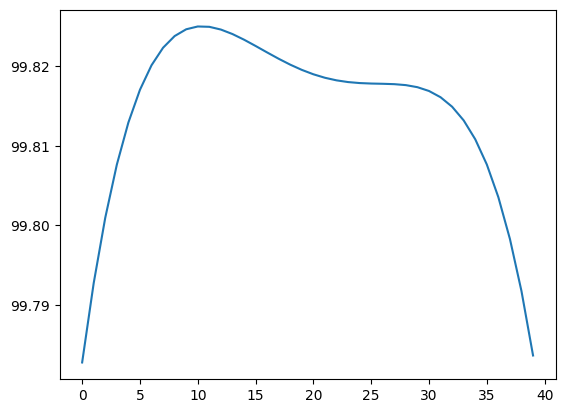

In [29]:
plt.plot(range(40), (1- variance_explained_in_1step[:,ialpha,0:40].mean(axis=0))*100)

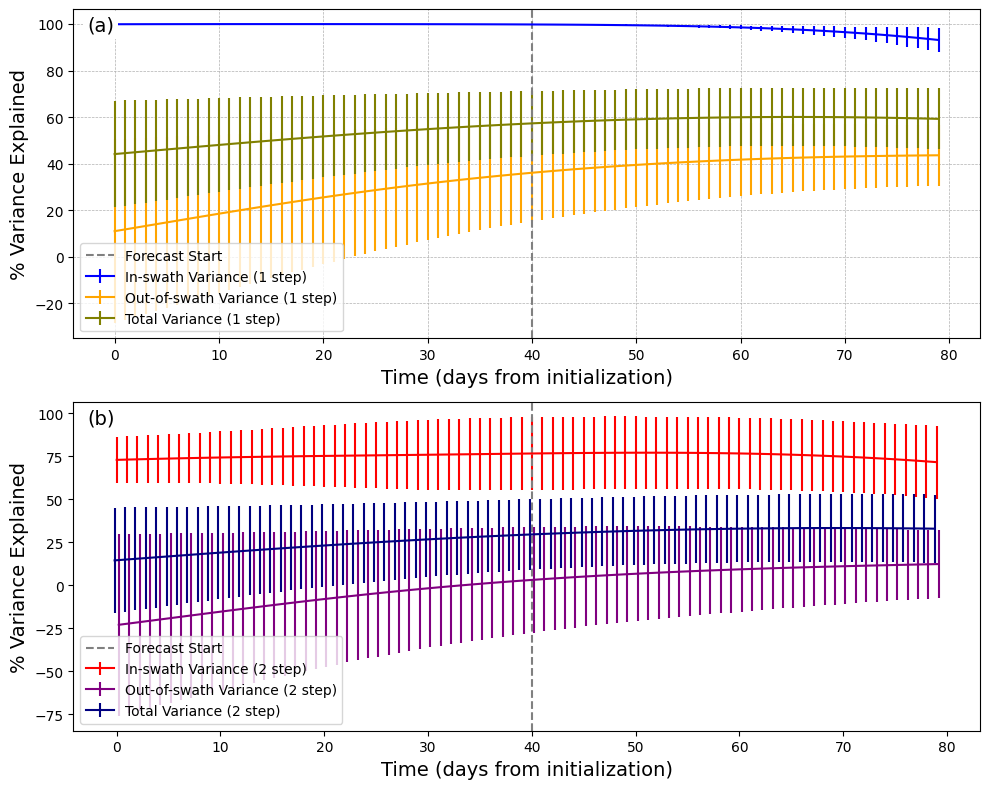

In [30]:
# Figure 8:  
# Set figure size and aspect ratio for landscape orientation
# fig, ax = plt.subplots(figsize=(10, 5))
import matplotlib.transforms as mtransforms
fig, ax = plt.subplots(2, figsize=(10, 8))
ialpha=6

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy']

# Line plots
ax[0].errorbar(range(time_range), (1- variance_explained_in_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_1step[:,ialpha,:].std(axis=0), label='In-swath Variance (1 step)', elinewidth=1.5, color=colors[0])
ax[0].errorbar(range(time_range), (1-variance_explained_out_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_1step[:,ialpha,:].std(axis=0), label='Out-of-swath Variance (1 step)', elinewidth=1.5, color=colors[1])
ax[1].errorbar(range(time_range), (1-variance_explained_in_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_2step[:,ialpha,:].std(axis=0), label='In-swath Variance (2 step)', elinewidth=1.5, color=colors[2])
ax[1].errorbar(np.arange(0.2,0.2+time_range,1), (1-variance_explained_out_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_2step[:,ialpha,:].std(axis=0), label='Out-of-swath Variance (2 step)', elinewidth=1.5, color=colors[3])
ax[0].errorbar(range(time_range), (1-variance_explained_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_1step[:,ialpha,:].std(axis=0), label='Total Variance (1 step)', elinewidth=1.5, color=colors[8])
ax[1].errorbar(np.arange(-0.2,-0.2+time_range,1), (1-variance_explained_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_2step[:,ialpha,:].std(axis=0), label='Total Variance (2 step)', elinewidth=1.5, color=colors[9])
# Dashed vertical line at x = 40
ax[0].axvline(time_range//2, color='gray', linestyle='--', label="Forecast Start")
ax[1].axvline(time_range//2, color='gray', linestyle='--', label="Forecast Start")

# Adjust plot properties for better clarity
# ax.set_title('SSH Variance Explained', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Time (days from initialization)', fontsize=14)
ax[0].set_ylabel('% Variance Explained', fontsize=14)
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
ax[0].text(0.0, 1.0, '(a)', transform=ax[0].transAxes + trans,
            fontsize=14, verticalalignment='top', 
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
            # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
# ax[0].text(-5,100,'a')
# ax[0].text(.1,.9,'a test',transform=ax[0].transaxes)

# ax.set_title('SSH Variance Explained', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Time (days from initialization)', fontsize=14)
ax[1].set_ylabel('% Variance Explained', fontsize=14)
# ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].text(0.0, 1.0, '(b)', transform=ax[1].transAxes + trans,
            fontsize=14, verticalalignment='top', 
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))

# Adjust legend position and size
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax[0].legend( fontsize=10)
# box = ax[1].get_position()
# ax[1].set_position([box.x1, box.y1, box.width * 0.75, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax[1].legend( fontsize=10)
plt.tight_layout()
plt.savefig('explained_variance_'+ str(int((day1 - day0))) +'days_'+ str(R) + '_' + str(alpha_std[ialpha])[:6] + '_' + str(sigma_scale) +'.png', dpi=300)
plt.show()

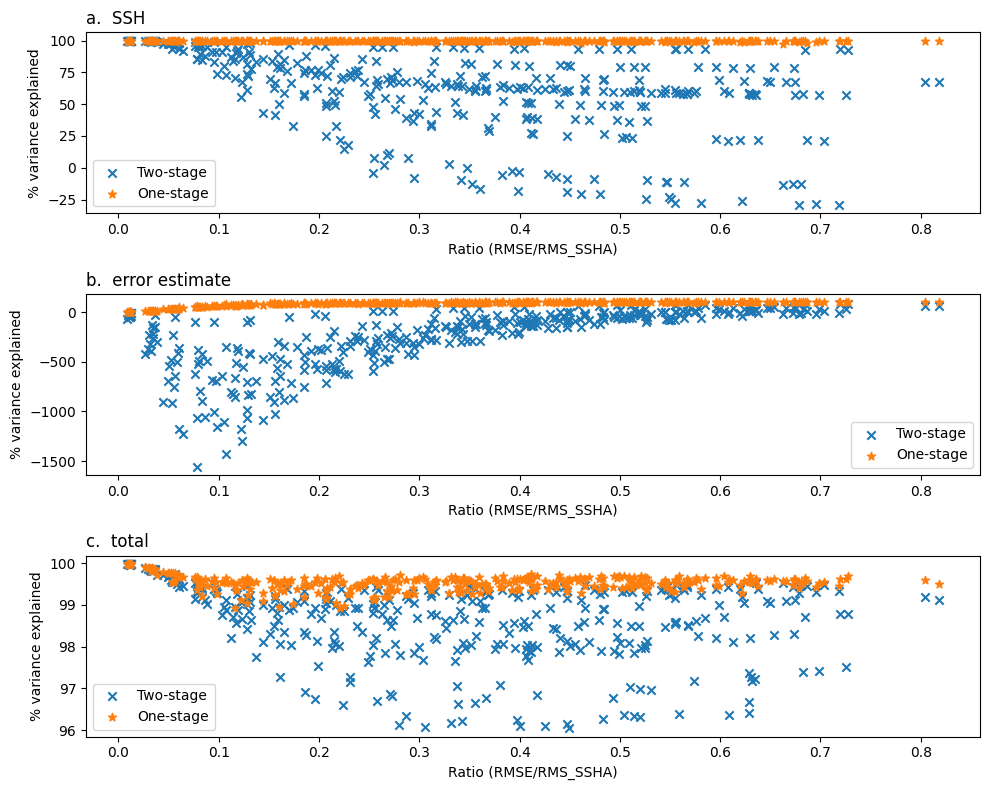

In [31]:
# Figure 7:  ensemble results for one-stage and two-stage approaches
    
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh , ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh , ssh_est_skill1, marker='*', label='One-stage')

axs[1].scatter(rmse_over_rmssh , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh , err_est_skill1, marker='*', label='One-stage')

axs[2].scatter(rmse_over_rmssh , total_est_skill2, marker='x', label='Two-stage')
axs[2].scatter(rmse_over_rmssh , total_est_skill1, marker='*', label='One-stage')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMS_SSHA)')
axs[0].set_ylabel('% variance explained')
axs[0].set_title('a.  SSH',loc='left')
axs[1].set_xlabel('Ratio (RMSE/RMS_SSHA)')
axs[1].set_ylabel('% variance explained')
axs[1].set_title('b.  error estimate',loc='left')
axs[2].set_xlabel('Ratio (RMSE/RMS_SSHA)')
axs[2].set_ylabel('% variance explained')
axs[2].set_title('c.  total',loc='left')

# Add legends
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Show plots
plt.tight_layout()
#plt.show()
plt.savefig('skill_ssh_errr_rmse_ratio' + str(R) + '_' + str(sigma_scale) + '.png', dpi = 300)

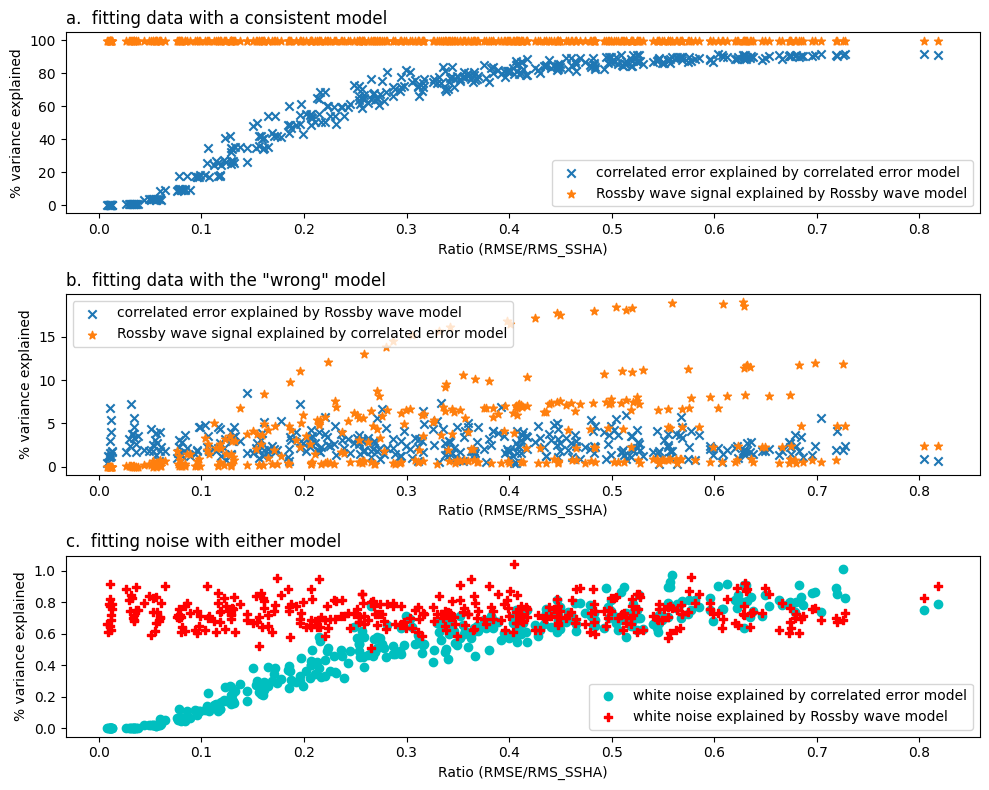

In [41]:
# Figure 5v2:  projection of error into Rossby wave and of Rossby waave into error
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh , err_proj_err, marker='x', label='correlated error explained by correlated error model')
axs[0].scatter(rmse_over_rmssh , ssh_proj_err2, marker='*', label='Rossby wave signal explained by Rossby wave model')

axs[1].scatter(rmse_over_rmssh , err_proj_err2, marker='x', label='correlated error explained by Rossby wave model')
axs[1].scatter(rmse_over_rmssh , ssh_proj_err, marker='*', label='Rossby wave signal explained by correlated error model')
axs[2].scatter(rmse_over_rmssh , noise_proj_err, color = 'c', marker='o', label='white noise explained by correlated error model')
axs[2].scatter(rmse_over_rmssh , noise_proj_err2, color = 'r', marker='P', label='white noise explained by Rossby wave model')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMS_SSHA)')
axs[0].set_ylabel('% variance explained')
axs[0].set_title('a.  fitting data with a consistent model',loc='left')
axs[1].set_xlabel('Ratio (RMSE/RMS_SSHA)')
axs[1].set_ylabel('% variance explained')
axs[1].set_title('b.  fitting data with the "wrong" model',loc='left')
axs[2].set_xlabel('Ratio (RMSE/RMS_SSHA)')
axs[2].set_ylabel('% variance explained')
axs[2].set_title('c.  fitting noise with either model',loc='left')

# Add legends
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Show plots
plt.tight_layout()
#plt.show()
plt.savefig('projections' + str(R) + '_' + str(sigma_scale) + '.png', dpi = 300)

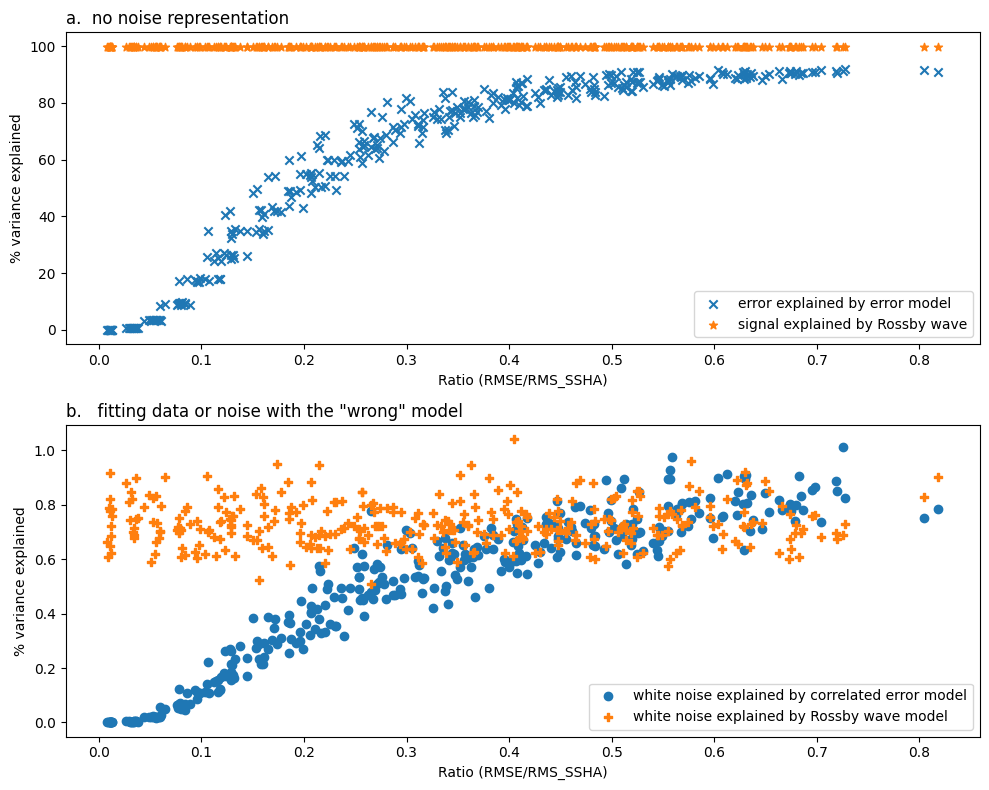

In [38]:
# Figure 5v2:  projection of error into Rossby wave and of Rossby waave into error
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh , err_proj_err, marker='x', label='error explained by error model')
axs[0].scatter(rmse_over_rmssh , ssh_proj_err2, marker='*', label='signal explained by Rossby wave')

#axs[1].scatter(rmse_over_rmssh , err_proj_err2, marker='x', label='error explained by Rossby wave model')
#axs[1].scatter(rmse_over_rmssh , ssh_proj_err, marker='x', label='Rossby wave signal explained by correlated error')
axs[1].scatter(rmse_over_rmssh , noise_proj_err, marker='o', label='white noise explained by correlated error model')
axs[1].scatter(rmse_over_rmssh , noise_proj_err2, marker='P', label='white noise explained by Rossby wave model')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMS_SSHA)')
axs[0].set_ylabel('% variance explained')
axs[0].set_title('a.  no noise representation',loc='left')
axs[1].set_xlabel('Ratio (RMSE/RMS_SSHA)')
axs[1].set_ylabel('% variance explained')
axs[1].set_title('b.   fitting data or noise with the "wrong" model',loc='left')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()
plt.savefig('noise_fit' + str(R) + '_' + str(sigma_scale) + '.png', dpi = 300)

In [36]:
np.mean(err_proj_err2), np.mean(ssh_proj_err), np.mean(noise_proj_err), np.mean(noise_proj_err2)

(np.float64(2.6334720217291894),
 np.float64(3.961943118494145),
 np.float64(0.4957701712595686),
 np.float64(0.7319814579452314))

# rmse_over_rmssh = rms_err / rms_ssh
rmse_over_rmssh2 = rms_err2 / rms_ssh2
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ratio_mean2 = rmse_over_rmssh2.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)
err_est_skill2_mean = err_est_skill2.mean(axis = 0)

In [ ]:
# only show error estimate skill greater than -100%
err_est_skill1_mean = np.ma.masked_less(err_est_skill1_mean, -100)
err_est_skill2_mean = np.ma.masked_less(err_est_skill2_mean, -100)

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh2, ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh2 , ssh_est_skill1, marker='*', label='One-stage')
axs[0].plot(ratio_mean2 , ssh_est_skill2_mean, linestyle = '-.', color = 'b', label='Two-stage ensemble mean')
axs[0].plot(ratio_mean2, ssh_est_skill1_mean, linestyle = '--', color = 'r', label='One-stage ensemble mean')


axs[1].scatter(rmse_over_rmssh2 , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh2 , err_est_skill1, marker='*', label='One-stage')
axs[1].plot(ratio_mean2 , err_est_skill2_mean, linestyle = '-.', color = 'b', label='Two-stage ensemble mean')
axs[1].plot(ratio_mean2 , err_est_skill1_mean, linestyle = '--', color = 'r', label='One-stage ensemble mean')
axs[1].axes.set_ylim(bottom=-100, top = 110)

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH)')
axs[0].set_ylabel('Variance explained by SSH estimate')
axs[1].set_xlabel('Ratio (RMSE/RMSSH)')
axs[1].set_ylabel('Variance explained by Error estimate')

# Add titles
axs[0].set_title('a) Variance explained SSH estimate for different RMSE values')
axs[1].set_title('b) Variance explained Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()

plt.savefig('skill_ssh_errr_rmse_ratio_mean_' + str(R) + '_' + str(sigma_scale) + '.png', dpi = 300)

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh, ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh , ssh_est_skill1, marker='*', label='One-stage')
axs[0].plot(ratio_mean , ssh_est_skill2_mean, linestyle = '-.', color = 'b', label='Two-stage ensemble mean')
axs[0].plot(ratio_mean, ssh_est_skill1_mean, linestyle = '--', color = 'r', label='One-stage ensemble mean')


axs[1].scatter(rmse_over_rmssh , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh , err_est_skill1, marker='*', label='One-stage')
axs[1].plot(ratio_mean , err_est_skill2_mean, linestyle = '-.', color = 'b', label='Two-stage ensemble mean')
axs[1].plot(ratio_mean , err_est_skill1_mean, linestyle = '--', color = 'r', label='One-stage ensemble mean')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH)')
axs[0].set_ylabel('Variance explained by SSH estimate')
axs[1].set_xlabel('Ratio (RMSE/RMSSH)')
axs[1].set_ylabel('Variance explained by Error estimate')

# Add titles
axs[0].set_title('a) Variance explained SSH estimate for different RMSE values')
axs[1].set_title('b) Variance explained Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()

plt.savefig('skill_ssh_errr_rmse_ratio_mean' + str(R) + '_' + str(sigma_scale) + '.png', dpi = 300)

In [ ]:
## test code---watch out as this resets exp
exp=0
k0 = l_n.max() # flat at or below k0
p_diagonal = np.zeros([2 * M + Tdim * 7*2])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(M), np.zeros(M)
counter = 0
# R = 0.01 # noise = 10. cm

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter] + k0) ** exp  * p_factor
        p_diagonal[2 * counter + 1] = (kl[counter] + k0) ** exp  * p_factor
        counter += 1

sigma = alpha_std[0]  # placeholder value  !!! move next 7 lines into loop
p_diagonal[2*M:] = sigma ** 2 # errors

R_over_P_test = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])

np.fill_diagonal(R_over_P_test[:],  R / p_diagonal )

In [ ]:
variance_explained_all=np.zeros([time_range,12])
variance_explained_persistence=np.zeros([time_range,12])
for n in range(12):
    wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
    variance_explained_all[:,n] = wave_ds.variance_explained.data
    variance_explained_persistence[:,n] = wave_ds.variance_explained_persistence.data

In [ ]:
# Figure 4:  Variance explained by fake data relative to true data
fig, ax = plt.subplots(figsize=(10, 5))

mean_persistence = 100*variance_explained_persistence[:,:].mean(axis=1)
std_err_persistence = 2*100*variance_explained_persistence[:,:].std(axis=1)/np.sqrt(12)
mean_variance = 100*variance_explained_all[:,:].mean(axis=1)
std_err_variance = 2*100*variance_explained_all[:,:].std(axis=1)/np.sqrt(12)

for i in range(12):
     ax.plot(range(time_range),100*variance_explained_all[:,i],color = 'gray',linewidth=0.5)
    
ax.axvline(time_range//2, color='gray', linestyle='--', label="forecast start")
ax.fill_between(range(time_range),mean_persistence+std_err_persistence,mean_persistence-std_err_persistence,linewidth=0,alpha=0.2,color='blue')
ax.plot(range(time_range),mean_persistence,linewidth=2,color='blue',label='persistence')
ax.fill_between(range(time_range),mean_variance+std_err_variance,mean_variance-std_err_variance,linewidth=0,alpha=0.2,color='red')
ax.plot(range(time_range),mean_variance,linewidth=2,color='red',label='propagating Rossby wave fit')
#ax.errorbar(range(time_range),100*variance_explained_persistence[:,:].mean(axis=1),yerr=100*variance_explained_persistence[:,:].std(axis=1),color='blue',linestyle='--')
#ax.errorbar(range(time_range),100*variance_explained_all[:,:].mean(axis=1),yerr=100*variance_explained_all[:,:].std(axis=1),color='red',linestyle='--')

ax.set_xlabel('Time (days from initialization)', fontsize=14)
ax.set_ylabel('% variance explained', fontsize=14)
ax.legend(fontsize=14)

plt.savefig('skill_relative_to_aviso.png', dpi = 300)

In [ ]:
print('average % skill improvement for Rossby wave model relative to persistence: ',np.mean(mean_variance[0:40]-mean_persistence[0:40]))